# Predictive Insights Youth Income Prediction Challenge


https://zindi.africa/competitions/predictive-insights-youth-income-prediction-challenge/datahttps://zindi.africa/competitions/predictive-insights-youth-income-prediction-challenge/data

# 1. MODEL PREPROCESSING

In [16]:
#pip install imbalanced-learn


Note: you may need to restart the kernel to use updated packages.


# Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pandas import read_csv
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import cross_val_predict


# Feature Engineering


# a) Features selection

In [2]:

# Load dataset
Train = read_csv("Train.csv")
Test = read_csv("Test.csv")

# Combine the two DataFrames into one
dataset = pd.concat([Train, Test], axis=0)

# Set index
dataset = dataset.set_index('Person_id') 

# Create 'Subjects_over_70' column
dataset['Subjects_over_70'] = dataset.apply(lambda row: row.astype(str).str.contains("80 - 100 %|70 - 79 %").sum(), axis=1)

# Create a list of selected categorical variables
selected_vars = ["Round", "Status", "Geography", "Province",
                 "Schoolquintile", "Math", "Mathlit", "Additional_lang", "Home_lang", "Science"]

# Add 'Year_survey' and 'Age_survey' columns
dataset['Year_survey'] = pd.to_datetime(dataset['Survey_date']).dt.year
dataset['Age_survey'] = dataset['Year_survey'] - dataset['Birthyear']

# Remove columns we won't use
dataset = dataset.drop(["Survey_date"], axis=1)  # 'Person_id' was already dropped by setting the index

# Convert categorical variables to dummy variables
dataset1 = pd.get_dummies(dataset, columns=selected_vars, drop_first=True, dummy_na=True)

# Fill missing values with zero
dataset1 = dataset1.fillna(0)

# Normalize  Tenure
dataset1['Tenure'] = (dataset1['Tenure'] - dataset1['Tenure'].min()) / (dataset1['Tenure'].max() - dataset1['Tenure'].min())
dataset1['Year_survey'] = (dataset1['Year_survey'] - dataset1['Year_survey'].min()) / (dataset1['Year_survey'].max() - dataset1['Year_survey'].min())
#dataset1['Age_survey'] = (dataset1['Age_survey'] - dataset1['Age_survey'].min()) / (dataset1['Age_survey'].max() - dataset1['Age_survey'].min())


In [3]:
dataset.head()

,Round,Status,Tenure,Geography,Province,Matric,Degree,Diploma,Schoolquintile,Math,...,Home_lang,Science,Female,Sa_citizen,Birthyear,Birthmonth,Target,Subjects_over_70,Year_survey,Age_survey
Person_id,,,,,,,,,,,,,,,,,,,,,
Id_eqz61wz7yn,2,studying,NaN,Rural,Mpumalanga,1.0,0.0,0.0,3.0,0 - 29 %,...,NaN,0 - 29 %,1,1,2000,5,0.0,0,2022,22
Id_kj5k3g5wud,4,unemployed,427.0,Suburb,North West,1.0,0.0,0.0,1.0,30 - 39 %,...,NaN,30 - 39 %,1,1,1989,4,1.0,0,2023,34
Id_9h0isj38y4,3,other,NaN,Urban,Free State,1.0,0.0,0.0,NaN,30 - 39 %,...,NaN,30 - 39 %,0,1,1996,7,1.0,0,2022,26
Id_5ch3zwpdef,2,unemployed,810.0,Urban,Eastern Cape,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,1,2000,1,0.0,0,2022,22
Id_g4elxibjej,4,studying,NaN,Urban,Limpopo,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1,1,1998,12,0.0,0,2023,25


In [4]:
dataset.describe()

,Round,Tenure,Matric,Degree,Diploma,Schoolquintile,Female,Sa_citizen,Birthyear,Birthmonth,Target,Subjects_over_70,Year_survey,Age_survey
count,5954.000000,3828.00000,4422.000000,3235.000000,3264.000000,3475.000000,5954.000000,5954.000000,5954.000000,5954.000000,4020.000000,5954.000000,5954.000000,5954.000000
mean,3.142761,584.19488,0.854138,0.079753,0.079657,2.698993,0.558448,0.999496,1997.446255,5.412832,0.271891,0.079274,2022.437857,24.991602
std,0.976341,635.36636,0.353007,0.270952,0.270803,1.328483,0.496614,0.022443,4.386832,3.793229,0.444989,0.323393,0.605355,4.348956
min,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1970.000000,1.000000,0.000000,0.000000,2021.000000,18.000000
25%,2.000000,94.00000,1.000000,0.000000,0.000000,2.000000,0.000000,1.000000,1995.000000,1.000000,0.000000,0.000000,2022.000000,22.000000
50%,3.000000,370.00000,1.000000,0.000000,0.000000,3.000000,1.000000,1.000000,1999.000000,5.000000,0.000000,0.000000,2022.000000,23.000000
75%,4.000000,810.00000,1.000000,0.000000,0.000000,4.000000,1.000000,1.000000,2000.000000,9.000000,1.000000,0.000000,2023.000000,27.000000
max,4.000000,3621.00000,1.000000,1.000000,1.000000,5.000000,1.000000,1.000000,2004.000000,12.000000,1.000000,3.000000,2023.000000,51.000000


# Exploratory Data Analysis (EDA)


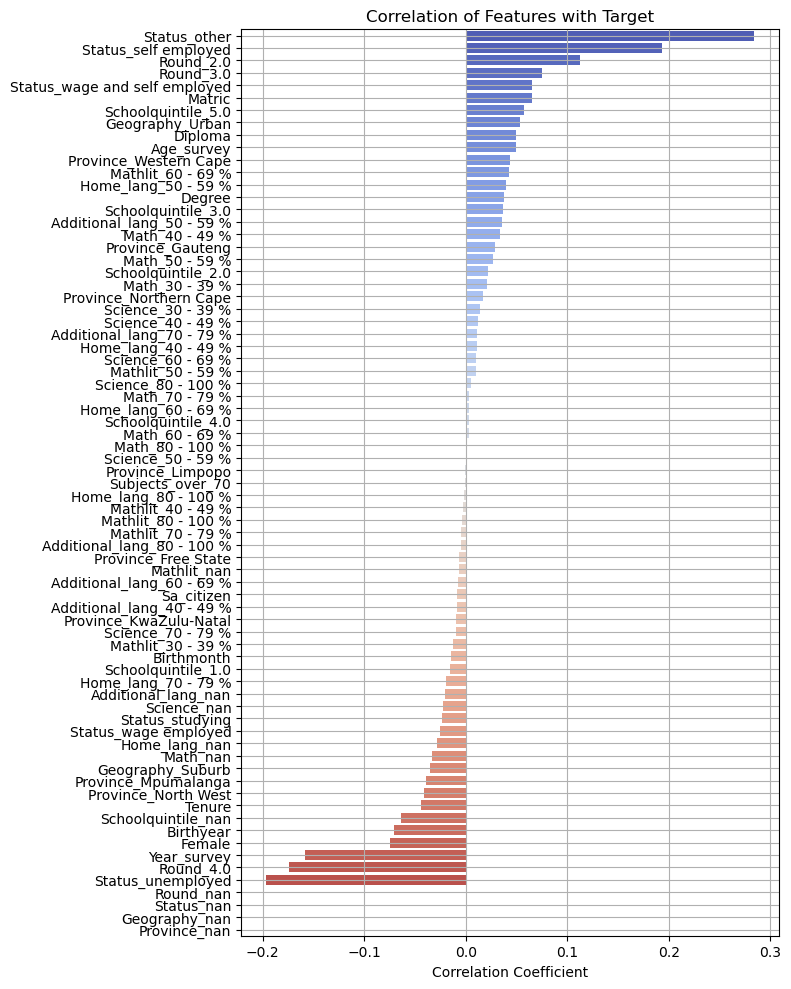

In [5]:
# Correlation of all features with the target
target_corr = dataset1.corr()['Target'].drop('Target').sort_values(ascending=False)

# Plot
plt.figure(figsize=(8, 10))
sns.barplot(x=target_corr.values, y=target_corr.index, palette='coolwarm')
plt.title('Correlation of Features with Target')
plt.xlabel('Correlation Coefficient')
plt.grid(True)
plt.tight_layout()
plt.show()


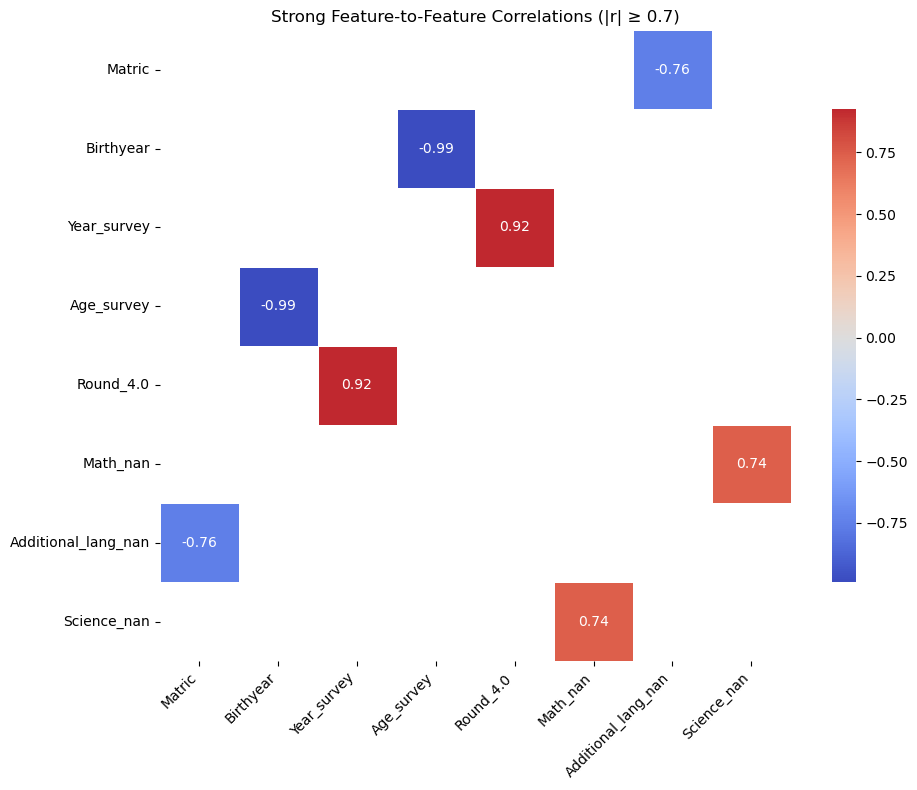

In [6]:
# Compute full correlation matrix
corr_matrix = dataset1.corr().dropna(axis=0, how='all').dropna(axis=1, how='all')

# Filter strong correlations (but exclude perfect 1.0s)
strong_corr = corr_matrix[(corr_matrix.abs() >= 0.7) & (corr_matrix.abs() < 1.0)]

# Drop rows and columns where all values are NaN
strong_corr = strong_corr.dropna(how='all', axis=0).dropna(how='all', axis=1)

# Plot heatmap of strong feature-to-feature correlations
plt.figure(figsize=(10, 8))
sns.heatmap(strong_corr, annot=True, fmt=".2f", cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.75})
plt.title('Strong Feature-to-Feature Correlations (|r| ≥ 0.7)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [7]:
# Get all feature pairs with correlation above 0.7 or below -0.7
def get_highly_correlated_pairs(corr_matrix, threshold=0.7):
    correlated_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            corr_val = corr_matrix.iloc[i, j]
            if abs(corr_val) >= threshold:
                correlated_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_val))
    return sorted(correlated_pairs, key=lambda x: abs(x[2]), reverse=True)

high_corr_pairs = get_highly_correlated_pairs(corr_matrix)

# Print top correlated pairs
print("Highly Correlated Feature Pairs (|r| ≥ 0.7):")
for f1, f2, corr_val in high_corr_pairs:
    print(f"{f1} ↔ {f2}: {corr_val:.2f}")


Highly Correlated Feature Pairs (|r| ≥ 0.7):
Age_survey ↔ Birthyear: -0.99
Round_4.0 ↔ Year_survey: 0.92
Additional_lang_nan ↔ Matric: -0.76
Science_nan ↔ Math_nan: 0.74


Dropping columns based on correlation redundancy


In [8]:
# Suggested drops based on correlation redundancy
columns_to_drop = [
    'Birthyear',            # Prefer Age_survey (usually more intuitive for modeling)
    'Round_4.0',            # Keep Year_survey instead (it's continuous)
    'Additional_lang_nan', # If Matric is more informative
    'Science_nan',          # If Math_nan covers more important subject area
    'Province_nan',
    'Geography_nan',
    'Status_nan',
    'Round_nan'
]

# Drop from feature set
dataset1 = dataset1.drop(columns=columns_to_drop, errors='ignore')


Dropping columns with zero linear correlation with Target


In [9]:

# Ensure 'Target' is in your dataset
assert 'Target' in dataset1.columns, "'Target' column not found in dataset."

# Compute correlation matrix
corr_matrix = dataset1.corr(numeric_only=True)

# Get correlations with the target
target_corr = corr_matrix['Target'].drop('Target')

# Filter features with correlation between -0.02 and 0.02
weak_corr_features = target_corr[(target_corr >= -0.015) & (target_corr <= 0.015)].index.tolist()

print(f"\n❌ Dropping {len(weak_corr_features)} weakly correlated features:")
print(weak_corr_features)

# Drop the weakly correlated features
dataset_cleaned = dataset1.drop(columns=weak_corr_features)



❌ Dropping 29 weakly correlated features:
['Sa_citizen', 'Birthmonth', 'Subjects_over_70', 'Province_Free State', 'Province_KwaZulu-Natal', 'Province_Limpopo', 'Schoolquintile_4.0', 'Math_60 - 69 %', 'Math_70 - 79 %', 'Math_80 - 100 %', 'Mathlit_30 - 39 %', 'Mathlit_40 - 49 %', 'Mathlit_50 - 59 %', 'Mathlit_70 - 79 %', 'Mathlit_80 - 100 %', 'Mathlit_nan', 'Additional_lang_40 - 49 %', 'Additional_lang_60 - 69 %', 'Additional_lang_70 - 79 %', 'Additional_lang_80 - 100 %', 'Home_lang_40 - 49 %', 'Home_lang_60 - 69 %', 'Home_lang_80 - 100 %', 'Science_30 - 39 %', 'Science_40 - 49 %', 'Science_50 - 59 %', 'Science_60 - 69 %', 'Science_70 - 79 %', 'Science_80 - 100 %']


In [10]:

# Split back into Train and Test
Train_df = dataset_cleaned.iloc[:-1934]  # Train dataset

# Split back into Train and Test
Test_dataset1 = dataset_cleaned.tail(1934)  # Test dataset
Test_dataset1 = Test_dataset1.drop('Target', axis=1)


In [11]:
dataset_cleaned.describe()


,Tenure,Matric,Degree,Diploma,Female,Target,Year_survey,Age_survey,Round_2.0,Round_3.0,...,Schoolquintile_nan,Math_30 - 39 %,Math_40 - 49 %,Math_50 - 59 %,Math_nan,Mathlit_60 - 69 %,Additional_lang_50 - 59 %,Home_lang_50 - 59 %,Home_lang_70 - 79 %,Home_lang_nan
count,5954.000000,5954.000000,5954.000000,5954.000000,5954.000000,5954.000000,5954.000000,5954.000000,5954.000000,5954.000000,...,5954.000000,5954.000000,5954.000000,5954.000000,5954.000000,5954.00000,5954.000000,5954.000000,5954.000000,5954.000000
mean,0.103727,0.634363,0.043332,0.043668,0.558448,0.183574,0.718928,24.991602,0.234968,0.206920,...,0.416359,0.074404,0.048539,0.025697,0.749412,0.03611,0.202049,0.034095,0.004535,0.905106
std,0.160529,0.481649,0.203621,0.204373,0.496614,0.387169,0.302678,4.348956,0.424014,0.405131,...,0.492996,0.262449,0.214920,0.158243,0.433388,0.18658,0.401562,0.181488,0.067193,0.293093
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,22.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000
50%,0.021403,1.000000,0.000000,0.000000,1.000000,0.000000,0.500000,23.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,1.000000
75%,0.142985,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,27.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,51.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


# 2. MODEL CHOICE and IMPLEMENTATION

# a) Baseline model :   LOGISTIC REGRESSION

Classification Report (No Balancing):
              precision    recall  f1-score   support

         0.0       0.82      0.95      0.88      2927
         1.0       0.75      0.43      0.54      1093

    accuracy                           0.81      4020
   macro avg       0.78      0.69      0.71      4020
weighted avg       0.80      0.81      0.79      4020

ROC AUC Score: 0.8091


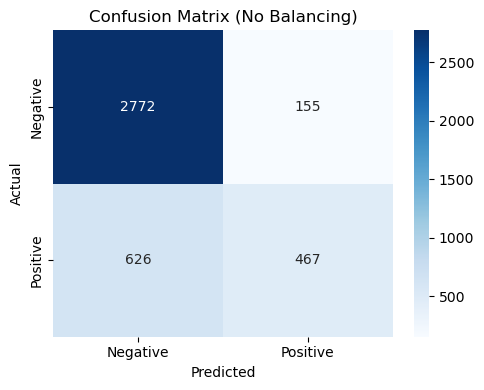

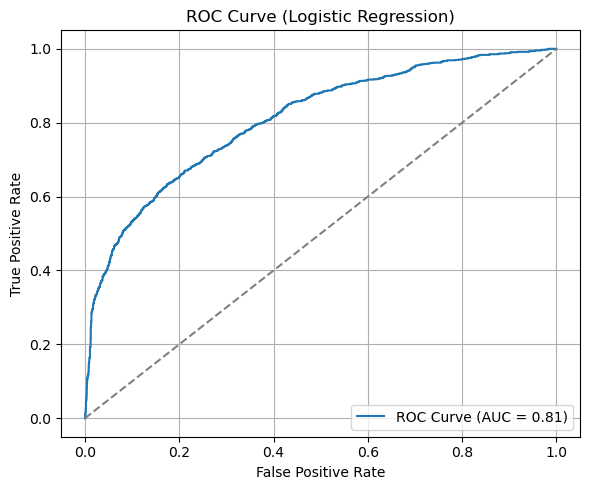

In [12]:


# Assume X and y are your original 
X = Train_df.drop('Target', axis=1)
y = Train_df['Target']

model = LogisticRegression(max_iter=1000, solver='lbfgs')

# 10-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Get cross-validated predicted class labels and predicted probabilities
y_pred = cross_val_predict(model, X, y, cv=cv)
y_prob = cross_val_predict(model, X, y, cv=cv, method='predict_proba')[:, 1]

# Print Classification Report
print("Classification Report (No Balancing):")
print(classification_report(y, y_pred))

# Print AUC
auc_score = roc_auc_score(y, y_prob)
print(f"ROC AUC Score: {auc_score:.4f}")

# Plot Confusion Matrix
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix (No Balancing)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y, y_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve (Logistic Regression)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


# b) Addressing Class imbalance

To check class imbalance and apply SMOTE (Synthetic Minority Over-sampling Technique) before training your LogisticRegression model

0.0    2927
1.0    2927
Name: Target, dtype: int64


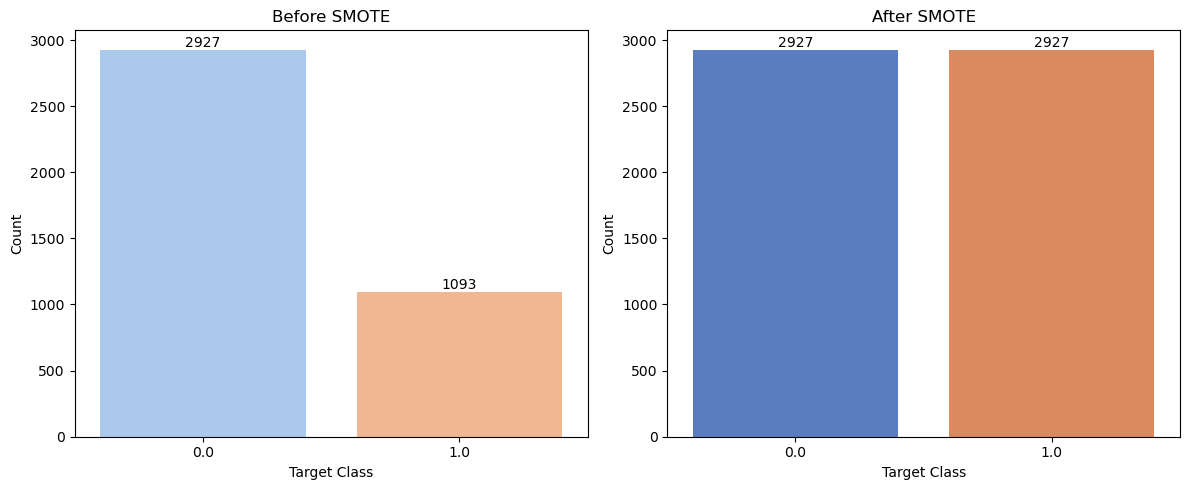

In [13]:
# Create SMOTE object
smote = SMOTE(random_state=42)

# Apply SMOTE to training data
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check new class distribution
print(pd.Series(y_resampled).value_counts())

# Plot class distribution before SMOTE
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Before SMOTE
sns.countplot(x=y, ax=axes[0], palette="pastel")
axes[0].set_title("Before SMOTE")
axes[0].set_xlabel("Target Class")
axes[0].set_ylabel("Count")
axes[0].bar_label(axes[0].containers[0])

# After SMOTE
sns.countplot(x=y_resampled, ax=axes[1], palette="muted")
axes[1].set_title("After SMOTE")
axes[1].set_xlabel("Target Class")
axes[1].set_ylabel("Count")
axes[1].bar_label(axes[1].containers[0])

plt.tight_layout()
plt.show()


# 0. Logistic regression with  SMOTE

Mean AUC (Cross-Validation): 0.8618050497073787


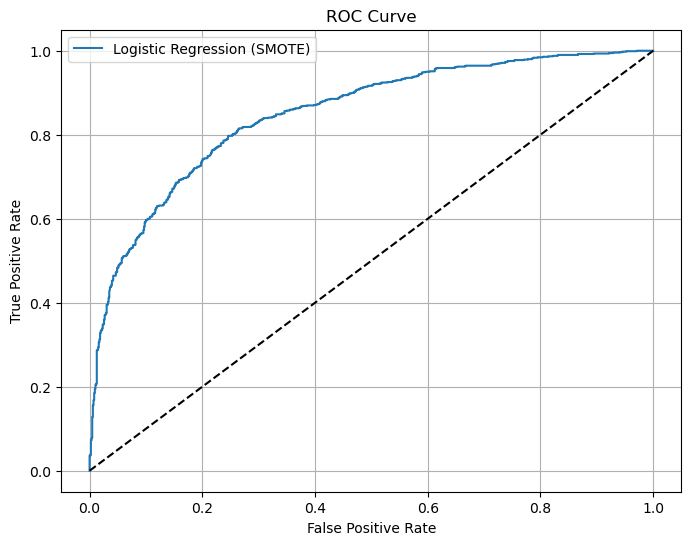

Confusion Matrix:
 [[687 172]
 [232 666]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.75      0.80      0.77       859
         1.0       0.79      0.74      0.77       898

    accuracy                           0.77      1757
   macro avg       0.77      0.77      0.77      1757
weighted avg       0.77      0.77      0.77      1757


Overall Precision: 0.7947
Overall Recall   : 0.7416
Overall Accuracy : 0.7701
Overall F1 Score : 0.7673


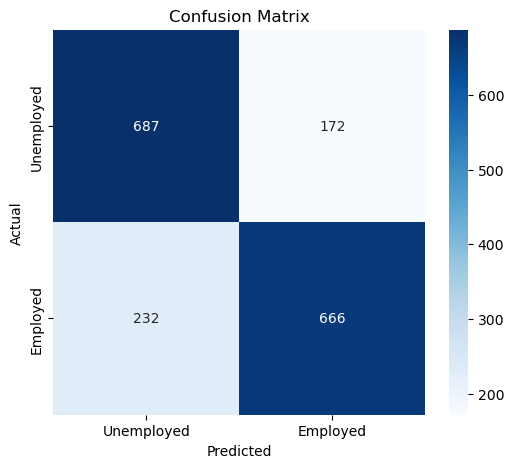


Test Predictions (first 5 rows):
               Predicted_Target
Person_id                      
Id_r90136smvl          0.971888
Id_wawdqhmu6s          0.173288
Id_ap2czff2bu          0.125525
Id_uhgink7iha          0.304021
Id_5j6bzk3k81          0.183211


In [14]:
# Step 1: Define X and y
X_s = Train_df.drop('Target', axis=1)
y_s = Train_df['Target']

# Step 2: Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_s, y_s)

# Step 3: Cross-validation with AUC scoring
model = LogisticRegression(max_iter=5000)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(model, X_resampled, y_resampled, cv=cv, scoring='roc_auc')

print("Mean AUC (Cross-Validation):", scores.mean())

# Step 4: Train/Test split on SMOTE data for evaluation
X_train, X_eval, y_train, y_eval = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
model.fit(X_train, y_train)

# Step 5: ROC Curve for validation set
y_probs_eval = model.predict_proba(X_eval)[:, 1]
fpr, tpr, _ = roc_curve(y_eval, y_probs_eval)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Logistic Regression (SMOTE)')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# Step 6: Confusion Matrix and Classification Report
y_pred_eval = model.predict(X_eval)
cm = confusion_matrix(y_eval, y_pred_eval)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:\n", classification_report(y_eval, y_pred_eval))

# Step 7: Overall evaluation metrics
precision = precision_score(y_eval, y_pred_eval)
recall = recall_score(y_eval, y_pred_eval)
accuracy = accuracy_score(y_eval, y_pred_eval)
f1 = f1_score(y_eval, y_pred_eval)

print(f"\nOverall Precision: {precision:.4f}")
print(f"Overall Recall   : {recall:.4f}")  # <- Explicitly added recall
print(f"Overall Accuracy : {accuracy:.4f}")
print(f"Overall F1 Score : {f1:.4f}")

# Optional: Plot the confusion matrix
import seaborn as sns
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Unemployed', 'Employed'],
            yticklabels=['Unemployed', 'Employed'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Step 8: Final model training on all resampled data
model.fit(X_resampled, y_resampled)

# Step 9: Predict on test dataset
X_test_final = Test_dataset1.drop(columns=['Target', 'Predicted_Target'], errors='ignore')

# Ensure feature columns match training set
if list(X_s.columns) != list(X_test_final.columns):
    raise ValueError("Feature columns in X_test do not match those in the training data.")

# Predict probabilities on the test set
y_probs_test = model.predict_proba(X_test_final)[:, 1]

# Add predictions to the test dataset
Test_dataset1['Predicted_Target'] = y_probs_test
print("\nTest Predictions (first 5 rows):")
print(Test_dataset1[['Predicted_Target']].head())


# IMPLEMENTATION

In [15]:

# === Prepare dataset ===
Test_dataset1 = dataset1.tail(1934).drop('Target', axis=1)
Train_dataset1 = dataset1.iloc[:-1934]

X = Train_dataset1.drop('Target', axis=1)
y = Train_dataset1['Target']

# === Define models ===
models = {
    "Logistic_Regression": LogisticRegression(max_iter=1000),
    "Random_Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient_Boosting": GradientBoostingClassifier(),
    "KNN_Classifier": KNeighborsClassifier(),
    "Decision_Tree": DecisionTreeClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# === Cross-validation settings ===
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

def plot_roc_curve_and_confusion_matrix(model_name, X, y, models, cv):
    if model_name not in models:
        print(f"Model '{model_name}' not found. Available models: {list(models.keys())}")
        return None

    model = models[model_name]
    print(f"\n{'='*10} {model_name} {'='*10}")

    tprs, aucs = [], []
    mean_fpr = np.linspace(0, 1, 100)
    cm_total = np.zeros((2, 2))

    y_true_all, y_pred_all = [], []

    plt.figure(figsize=(10, 8))

    for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
        X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
        y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train_cv, y_train_cv)
        y_probs = model.predict_proba(X_test_cv)[:, 1]
        y_pred = model.predict(X_test_cv)

        y_true_all.extend(y_test_cv)
        y_pred_all.extend(y_pred)

        fpr, tpr, _ = roc_curve(y_test_cv, y_probs)
        auc_score = roc_auc_score(y_test_cv, y_probs)
        aucs.append(auc_score)

        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)

        plt.plot(fpr, tpr, lw=1, alpha=0.7, label=f'Fold {fold_idx} (AUC = {auc_score:.2f})')
        cm_total += confusion_matrix(y_test_cv, y_pred)

    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)

    plt.plot(mean_fpr, mean_tpr, color='black', lw=2,
             label=f'Mean ROC (AUC = {mean_auc:.3f} ± {std_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title(f'ROC Curves for All 10 Folds: {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    # Confusion Matrix
    cm_avg = cm_total / cv.get_n_splits()
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm_avg, annot=True, fmt='.3f', cmap='Blues', cbar=False,
                xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.title(f'Average Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Metrics
    precision = precision_score(y_true_all, y_pred_all)
    recall = recall_score(y_true_all, y_pred_all)
    accuracy = accuracy_score(y_true_all, y_pred_all)
    f1 = f1_score(y_true_all, y_pred_all)

    print("\n--- Performance Metrics ---")
    print(f"Precision (TP / (TP + FP)) : {precision:.4f}")
    print(f"Recall    (TP / (TP + FN)) : {recall:.4f}")
    print(f"Accuracy                     : {accuracy:.4f}")
    print(f"F1 Score                     : {f1:.4f}")

    print("\n--- y_eval (Ground truth labels from CV) ---")
    print(pd.Series(y_true_all).value_counts())

    return model


C:\Users\43197\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


# 1. BASELINE MODEL:   LOGISTIC REGRESSION


========== Logistic_Regression ==========


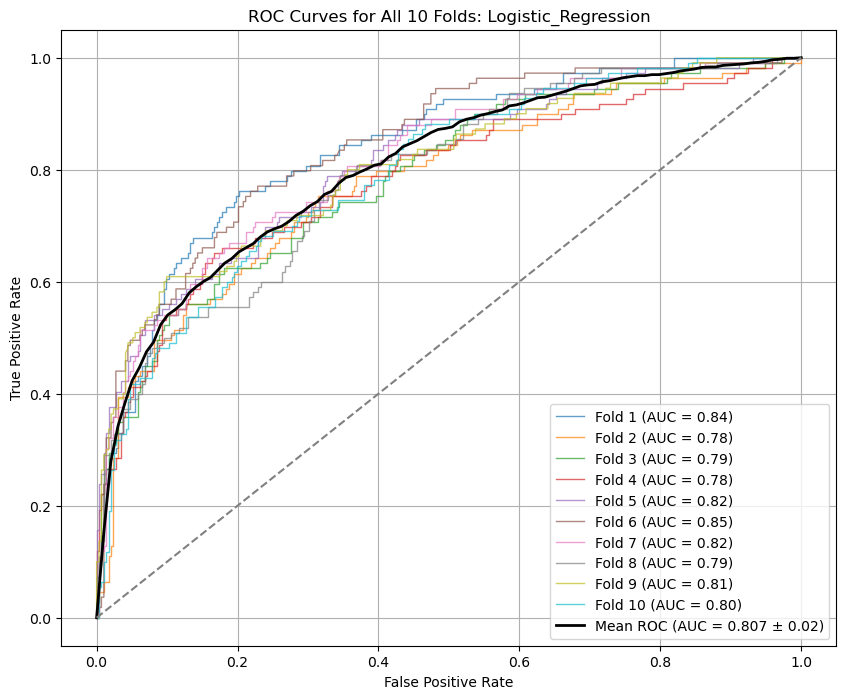

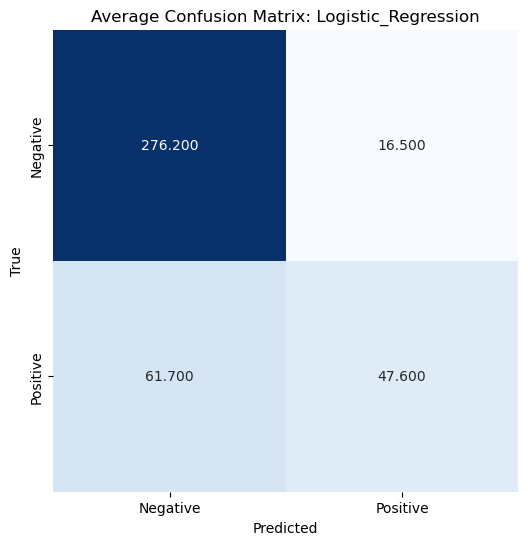


--- Performance Metrics ---
Precision (TP / (TP + FP)) : 0.7426
Recall    (TP / (TP + FN)) : 0.4355
Accuracy                     : 0.8055
F1 Score                     : 0.5490

--- y_eval (Ground truth labels from CV) ---
0.0    2927
1.0    1093
dtype: int64

First few predicted probabilities on test set:
                 Target
Person_id              
Id_r90136smvl  0.835397
Id_wawdqhmu6s  0.113700
Id_ap2czff2bu  0.076370
Id_uhgink7iha  0.085256
Id_5j6bzk3k81  0.109121


In [16]:

selected_model = 'Logistic_Regression'
# Wait for user input for model selection
#selected_model = input(f"Select model name from the following options {list(models.keys())}: ").strip()

# Run training and evaluation
trained_model = plot_roc_curve_and_confusion_matrix(selected_model, X, y, models, cv)

if trained_model is not None:
    # Prepare test set to match training columns
    X_test_final = Test_dataset1.copy()

    # Add missing columns with zeros
    missing_cols = set(X.columns) - set(X_test_final.columns)
    for col in missing_cols:
        X_test_final[col] = 0

    # Reorder columns to match training data
    X_test_final = X_test_final[X.columns]

    # Predict probabilities on test set using the trained model
    Test_dataset1['Target'] = trained_model.predict_proba(X_test_final)[:, 1]

    # Show first few predicted probabilities
    print("\nFirst few predicted probabilities on test set:")
    print(Test_dataset1[['Target']].head())
else:
    print("Model training was not completed due to invalid model selection.")


# 2. Gradient Boosting


========== Gradient_Boosting ==========


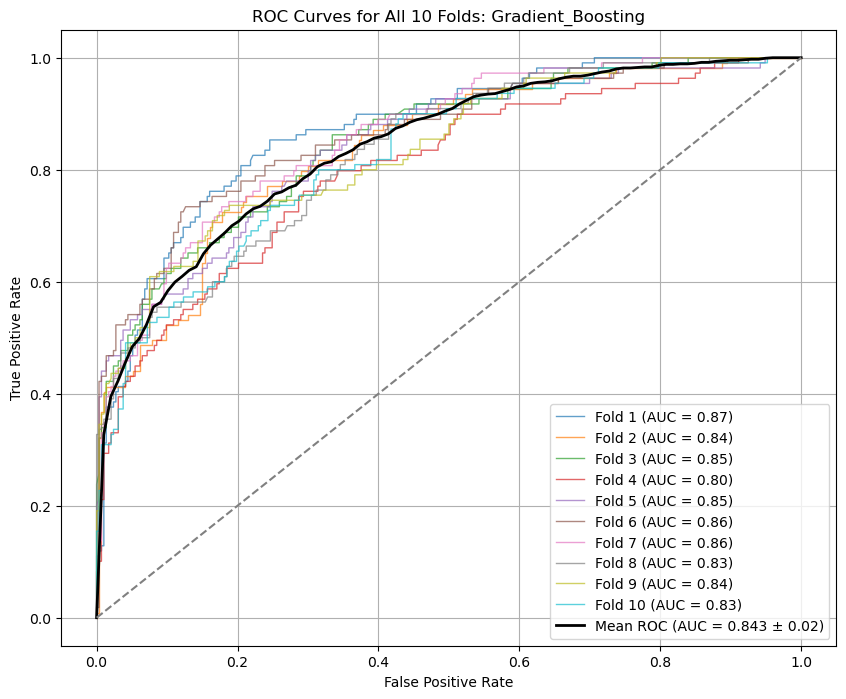

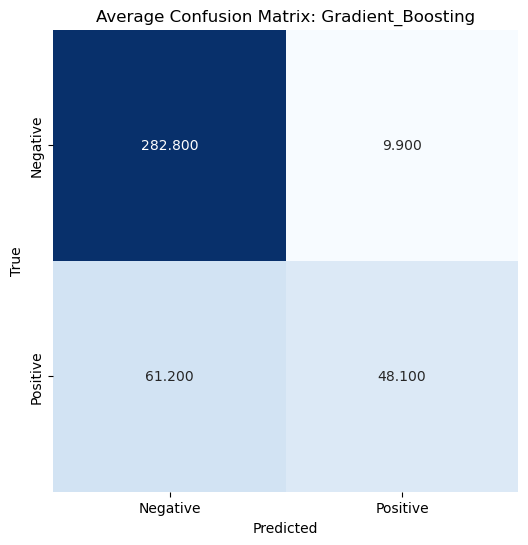


--- Performance Metrics ---
Precision (TP / (TP + FP)) : 0.8293
Recall    (TP / (TP + FN)) : 0.4401
Accuracy                     : 0.8231
F1 Score                     : 0.5750

--- y_eval (Ground truth labels from CV) ---
0.0    2927
1.0    1093
dtype: int64

First few predicted probabilities on test set:
                 Target
Person_id              
Id_r90136smvl  0.953004
Id_wawdqhmu6s  0.148238
Id_ap2czff2bu  0.143285
Id_uhgink7iha  0.125425
Id_5j6bzk3k81  0.148009


In [17]:

selected_model = "Gradient_Boosting"
# Wait for user input for model selection
#selected_model = input(f"Select model name from the following options {list(models.keys())}: ").strip()

# Run training and evaluation
trained_model = plot_roc_curve_and_confusion_matrix(selected_model, X, y, models, cv)

if trained_model is not None:
    # Prepare test set to match training columns
    X_test_final = Test_dataset1.copy()

    # Add missing columns with zeros
    missing_cols = set(X.columns) - set(X_test_final.columns)
    for col in missing_cols:
        X_test_final[col] = 0

    # Reorder columns to match training data
    X_test_final = X_test_final[X.columns]

    # Predict probabilities on test set using the trained model
    Test_dataset1['Target'] = trained_model.predict_proba(X_test_final)[:, 1]

    # Show first few predicted probabilities
    print("\nFirst few predicted probabilities on test set:")
    print(Test_dataset1[['Target']].head())
else:
    print("Model training was not completed due to invalid model selection.")


# 3. Decision Tree


========== Decision_Tree ==========


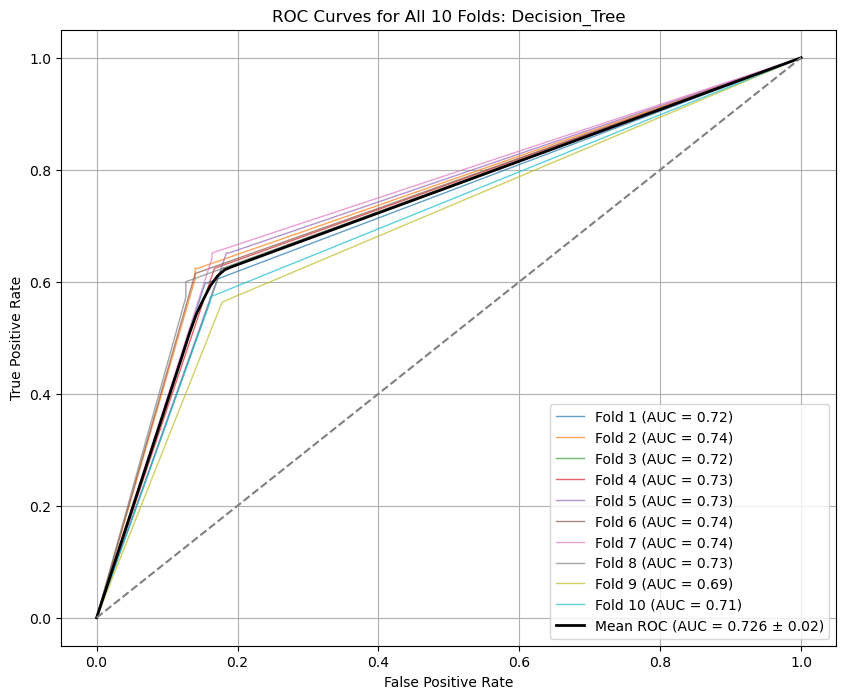

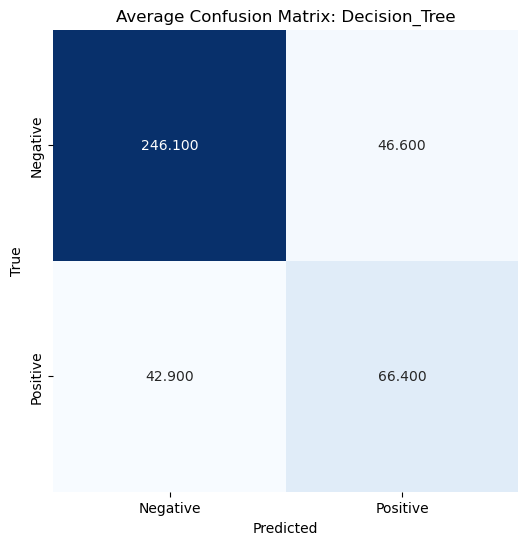


--- Performance Metrics ---
Precision (TP / (TP + FP)) : 0.5876
Recall    (TP / (TP + FN)) : 0.6075
Accuracy                     : 0.7774
F1 Score                     : 0.5974

--- y_eval (Ground truth labels from CV) ---
0.0    2927
1.0    1093
dtype: int64

First few predicted probabilities on test set:
               Target
Person_id            
Id_r90136smvl     1.0
Id_wawdqhmu6s     0.0
Id_ap2czff2bu     0.0
Id_uhgink7iha     0.0
Id_5j6bzk3k81     0.0


In [18]:

selected_model = "Decision_Tree"
# Wait for user input for model selection
#selected_model = input(f"Select model name from the following options {list(models.keys())}: ").strip()

# Run training and evaluation
trained_model = plot_roc_curve_and_confusion_matrix(selected_model, X, y, models, cv)

if trained_model is not None:
    # Prepare test set to match training columns
    X_test_final = Test_dataset1.copy()

    # Add missing columns with zeros
    missing_cols = set(X.columns) - set(X_test_final.columns)
    for col in missing_cols:
        X_test_final[col] = 0

    # Reorder columns to match training data
    X_test_final = X_test_final[X.columns]

    # Predict probabilities on test set using the trained model
    Test_dataset1['Target'] = trained_model.predict_proba(X_test_final)[:, 1]

    # Show first few predicted probabilities
    print("\nFirst few predicted probabilities on test set:")
    print(Test_dataset1[['Target']].head())
else:
    print("Model training was not completed due to invalid model selection.")


# 4. Random Forest


========== Random_Forest ==========


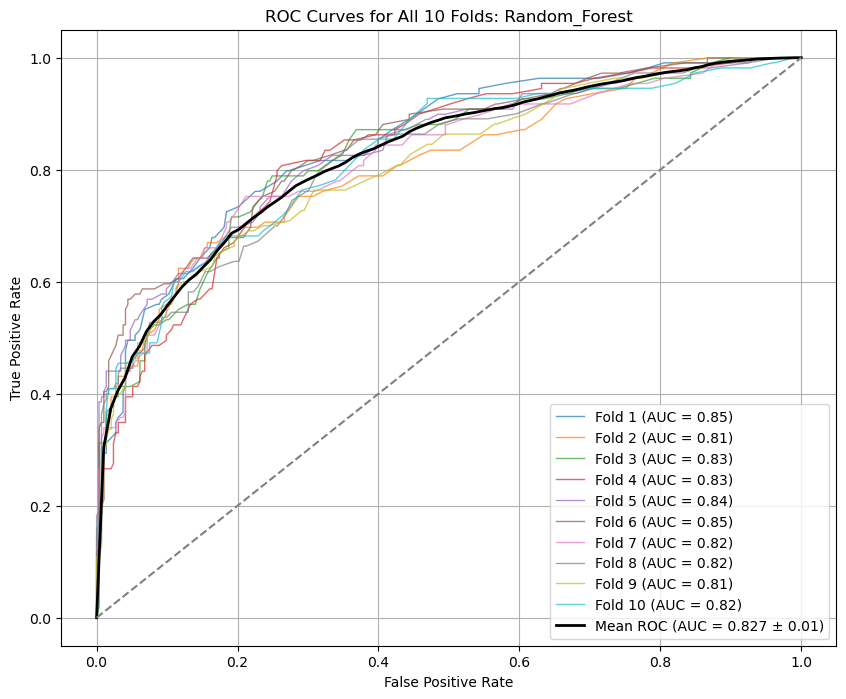

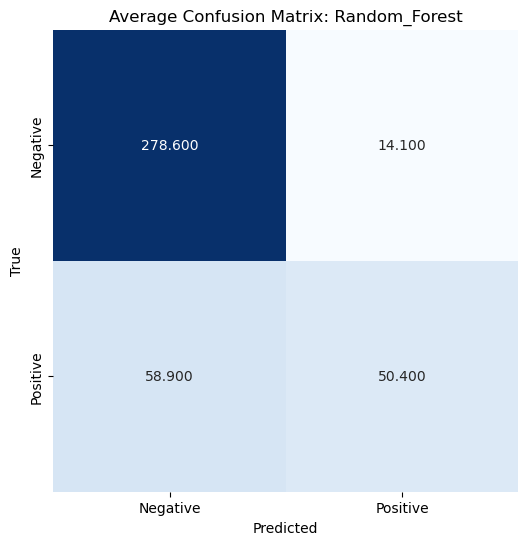


--- Performance Metrics ---
Precision (TP / (TP + FP)) : 0.7814
Recall    (TP / (TP + FN)) : 0.4611
Accuracy                     : 0.8184
F1 Score                     : 0.5800

--- y_eval (Ground truth labels from CV) ---
0.0    2927
1.0    1093
dtype: int64

First few predicted probabilities on test set:
               Target
Person_id            
Id_r90136smvl    0.94
Id_wawdqhmu6s    0.21
Id_ap2czff2bu    0.23
Id_uhgink7iha    0.18
Id_5j6bzk3k81    0.09


In [19]:

selected_model = "Random_Forest"
# Wait for user input for model selection
#selected_model = input(f"Select model name from the following options {list(models.keys())}: ").strip()

# Run training and evaluation
trained_model = plot_roc_curve_and_confusion_matrix(selected_model, X, y, models, cv)

if trained_model is not None:
    # Prepare test set to match training columns
    X_test_final = Test_dataset1.copy()

    # Add missing columns with zeros
    missing_cols = set(X.columns) - set(X_test_final.columns)
    for col in missing_cols:
        X_test_final[col] = 0

    # Reorder columns to match training data
    X_test_final = X_test_final[X.columns]

    # Predict probabilities on test set using the trained model
    Test_dataset1['Target'] = trained_model.predict_proba(X_test_final)[:, 1]

    # Show first few predicted probabilities
    print("\nFirst few predicted probabilities on test set:")
    print(Test_dataset1[['Target']].head())
else:
    print("Model training was not completed due to invalid model selection.")


# 5. KNN Classifier


========== KNN_Classifier ==========


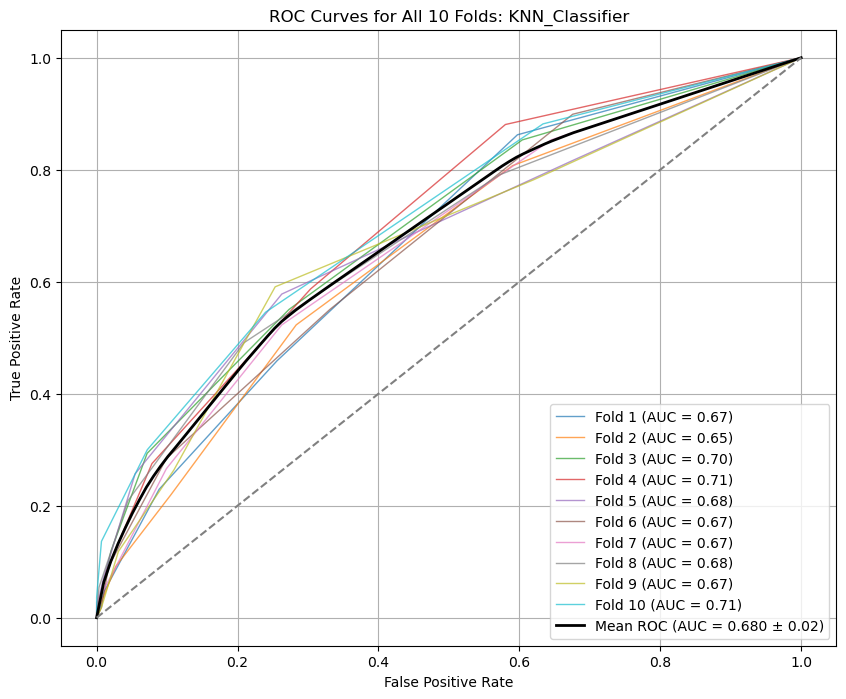

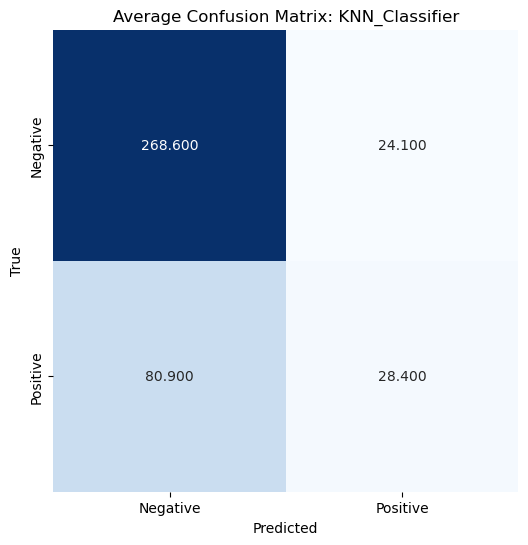


--- Performance Metrics ---
Precision (TP / (TP + FP)) : 0.5410
Recall    (TP / (TP + FN)) : 0.2598
Accuracy                     : 0.7388
F1 Score                     : 0.3511

--- y_eval (Ground truth labels from CV) ---
0.0    2927
1.0    1093
dtype: int64

First few predicted probabilities on test set:
               Target
Person_id            
Id_r90136smvl     0.2
Id_wawdqhmu6s     0.2
Id_ap2czff2bu     0.2
Id_uhgink7iha     0.0
Id_5j6bzk3k81     0.0


In [20]:

selected_model = "KNN_Classifier"
# Wait for user input for model selection
#selected_model = input(f"Select model name from the following options {list(models.keys())}: ").strip()

# Run training and evaluation
trained_model = plot_roc_curve_and_confusion_matrix(selected_model, X, y, models, cv)

if trained_model is not None:
    # Prepare test set to match training columns
    X_test_final = Test_dataset1.copy()

    # Add missing columns with zeros
    missing_cols = set(X.columns) - set(X_test_final.columns)
    for col in missing_cols:
        X_test_final[col] = 0

    # Reorder columns to match training data
    X_test_final = X_test_final[X.columns]

    # Predict probabilities on test set using the trained model
    Test_dataset1['Target'] = trained_model.predict_proba(X_test_final)[:, 1]

    # Show first few predicted probabilities
    print("\nFirst few predicted probabilities on test set:")
    print(Test_dataset1[['Target']].head())
else:
    print("Model training was not completed due to invalid model selection.")


# 6. xgboost


========== XGBoost ==========


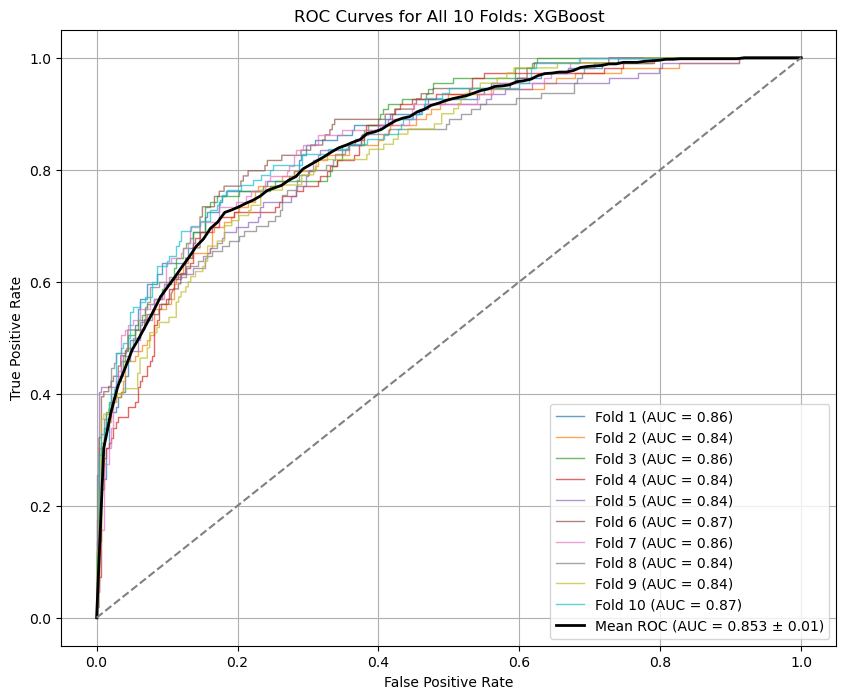

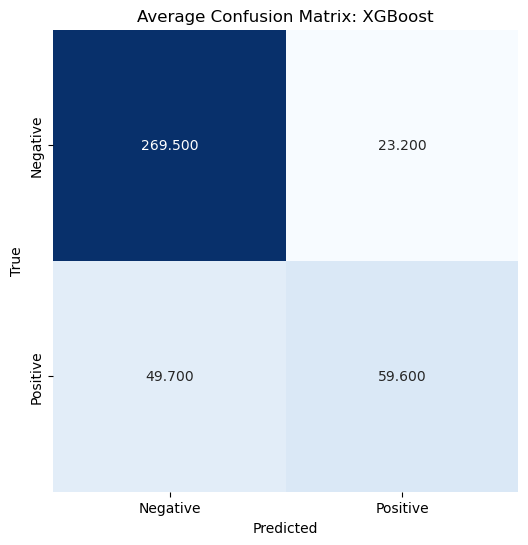


--- Performance Metrics ---
Precision (TP / (TP + FP)) : 0.7198
Recall    (TP / (TP + FN)) : 0.5453
Accuracy                     : 0.8187
F1 Score                     : 0.6205

--- y_eval (Ground truth labels from CV) ---
0.0    2927
1.0    1093
dtype: int64

First few predicted probabilities on test set:
                 Target
Person_id              
Id_r90136smvl  0.996827
Id_wawdqhmu6s  0.126190
Id_ap2czff2bu  0.048204
Id_uhgink7iha  0.052048
Id_5j6bzk3k81  0.043226


In [21]:

selected_model = "XGBoost"
# Wait for user input for model selection
#selected_model = input(f"Select model name from the following options {list(models.keys())}: ").strip()

# Run training and evaluation
trained_model = plot_roc_curve_and_confusion_matrix(selected_model, X, y, models, cv)

if trained_model is not None:
    # Prepare test set to match training columns
    X_test_final = Test_dataset1.copy()

    # Add missing columns with zeros
    missing_cols = set(X.columns) - set(X_test_final.columns)
    for col in missing_cols:
        X_test_final[col] = 0

    # Reorder columns to match training data
    X_test_final = X_test_final[X.columns]

    # Predict probabilities on test set using the trained model
    Test_dataset1['Target'] = trained_model.predict_proba(X_test_final)[:, 1]

    # Show first few predicted probabilities
    print("\nFirst few predicted probabilities on test set:")
    print(Test_dataset1[['Target']].head())
else:
    print("Model training was not completed due to invalid model selection.")


In [22]:
# Predict the target for Test_df1 using the selected model (e.g., XGBoost)
print("Random_Forest, Gradient_Boosting, XGBoost")
model_name = input("Enter one of the 3 model name here: ") # You can change this to any model in the dictionary

# Define models (excluding logistic regression which is handled separately)
models = {
    "Random_Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient_Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Get user input for model name
#model_name = input("Enter the model name: ")

# Check if the selected model exists
if model_name in models:
    model = models[model_name]
    
    # Fit model on full training data
    model.fit(X, y)

    # Prepare test data
    X_test_final = Test_dataset1.drop(columns=['Target','Predicted_Target','Predicted_Probability'], errors='ignore')

    # Validate that test columns match training columns
    if list(X.columns) != list(X_test_final.columns):
        raise ValueError("Feature columns in X_test do not match those in training data.")

    # Predict probabilities and add to test dataset
    Test_dataset1['Predicted_Probability'] = model.predict_proba(X_test_final)[:, 1]

    # Predict class labels
    Test_dataset1['Predicted_Target'] = model.predict(X_test_final)

    # Display first few prediction results
    print("\n=== Predictions (first 5 rows) ===")
    print(Test_dataset1[['Predicted_Probability', 'Predicted_Target']].head())

else:
    print(f"\n❌ Model '{model_name}' not found. Available models are:")
    for name in models.keys():
        print(f"  - {name}")


Random_Forest, Gradient_Boosting, XGBoost
Enter one of the 3 model name here: Random_Forest


C:\Users\43197\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")



=== Predictions (first 5 rows) ===
               Predicted_Probability  Predicted_Target
Person_id                                             
Id_r90136smvl                   0.82               1.0
Id_wawdqhmu6s                   0.30               0.0
Id_ap2czff2bu                   0.13               0.0
Id_uhgink7iha                   0.21               0.0
Id_5j6bzk3k81                   0.07               0.0


In [23]:

if model_name in models:
    model = models[model_name]

    # Fit model on training data
    model.fit(X, y)

    
    # Step 7: Predict on test dataset
    # Make sure test set is prepared the same way
    X_test_final = Test_dataset1.drop(columns=['Target', 'Predicted_Target','Predicted_Probability'], errors='ignore')

    # Ensure feature columns match
    if list(X.columns) != list(X_test_final.columns):
        raise ValueError("Feature columns in X_test do not match those in the training data.")

    # Predict probabilities
    y_probs_test = model.predict_proba(X_test_final)[:, 1]

    # Save predictions to test set
    Test_dataset1['Predicted_Target'] = y_probs_test  
    
else:
    print(f"\n❌ Model '{model_name}' not found. Available models are:")
    for name in models:
        print(f"  - {name}")


In [24]:
# Add missing columns to test set with default value 0
missing_cols = set(X.columns) - set(X_test_final.columns)
for col in missing_cols:
    X_test_final[col] = 0

# Drop extra columns from test set
extra_cols = set(X_test_final.columns) - set(X.columns)
X_test_final.drop(columns=extra_cols, inplace=True)

# Reorder columns to match training data
X_test_final = X_test_final[X.columns]

Test_dataset1['Target'] = model.predict_proba(X_test_final)[:, 1]
print(Test_dataset1[['Target']].head())


               Target
Person_id            
Id_r90136smvl    0.82
Id_wawdqhmu6s    0.30
Id_ap2czff2bu    0.13
Id_uhgink7iha    0.21
Id_5j6bzk3k81    0.07


In [124]:
Test_dataset1['Target'] = model.predict_proba(X_test_final)[:, 1]
df_submission = Test_dataset1[['Target']]
df_submission.to_csv("submission.csv", index=True)


In [267]:
Test_dataset1['Predicted_Target'] = model.predict(X_test)
print(Test_dataset1[['Predicted_Target']].head())


               Predicted_Target
Person_id                      
Id_r90136smvl                 1
Id_wawdqhmu6s                 0
Id_ap2czff2bu                 0
Id_uhgink7iha                 0
Id_5j6bzk3k81                 0


# Logistic regression with Class weight balanced method

Mean AUC (Cross-Validation): 0.8102857901854794


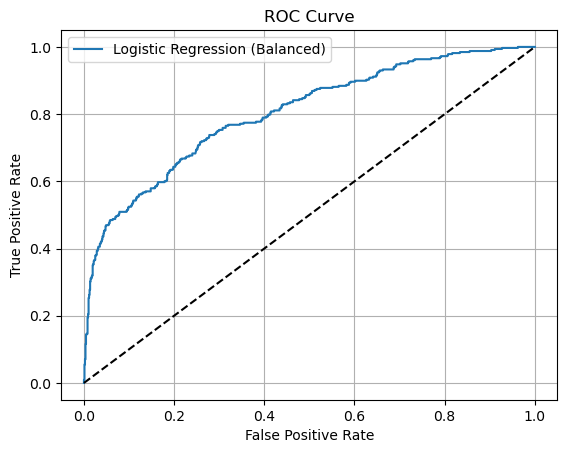

Confusion Matrix:
 [[696 182]
 [113 215]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.79      0.83       878
         1.0       0.54      0.66      0.59       328

    accuracy                           0.76      1206
   macro avg       0.70      0.72      0.71      1206
weighted avg       0.77      0.76      0.76      1206


Overall Precision: 0.5416
Overall Accuracy: 0.7554
Overall F1 Score: 0.5931
               Predicted_Target
Person_id                      
Id_r90136smvl          0.949084
Id_wawdqhmu6s          0.313184
Id_ap2czff2bu          0.192953
Id_uhgink7iha          0.383696
Id_5j6bzk3k81          0.282204


In [16]:

# Step 1: Define X and y
X_b = Train_df.drop('Target', axis=1)
y_b = Train_df['Target']

# Step 2: Logistic Regression with class_weight='balanced'
model = LogisticRegression(class_weight='balanced', max_iter=1000)

# Step 3: Cross-validation with AUC scoring
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_b, y_b, cv=cv, scoring='roc_auc')
print("Mean AUC (Cross-Validation):", scores.mean())

# Step 4: Train/Test split for evaluation
X_train, X_eval, y_train, y_eval = train_test_split(X_b, y_b, test_size=0.3, stratify=y_b, random_state=42)
model.fit(X_train, y_train)

# Step 5: ROC Curve for evaluation set
y_probs_eval = model.predict_proba(X_eval)[:, 1]
fpr, tpr, _ = roc_curve(y_eval, y_probs_eval)
plt.plot(fpr, tpr, label='Logistic Regression (Balanced)')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

# Optional: Confusion Matrix and Classification Report
y_pred_eval = model.predict(X_eval)
print("Confusion Matrix:\n", confusion_matrix(y_eval, y_pred_eval))
print("\nClassification Report:\n", classification_report(y_eval, y_pred_eval))


# Overall evaluation metrics (not class-specific)
precision = precision_score(y_eval, y_pred_eval)
accuracy = accuracy_score(y_eval, y_pred_eval)
f1 = f1_score(y_eval, y_pred_eval)

print(f"\nOverall Precision: {precision:.4f}")
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Overall F1 Score: {f1:.4f}")


# Step 6: Final training on full data
model.fit(X_b, y_b)

# Step 7: Predict on test dataset
# Make sure test set is prepared the same way
X_test_final = Test_dataset1.drop(columns=['Target', 'Predicted_Target'], errors='ignore')

# Ensure feature columns match
if list(X.columns) != list(X_test_final.columns):
    raise ValueError("Feature columns in X_test do not match those in the training data.")

# Predict probabilities
y_probs_test = model.predict_proba(X_test_final)[:, 1]

# Save predictions to test set
Test_dataset1['Predicted_Target'] = y_probs_test
print(Test_dataset1[['Predicted_Target']].head())


In [33]:

# Define models (excluding logistic, which we handle separately)
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(),
    "KNN Classifier": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Setup Stratified K-Fold
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Function to evaluate model performance
def evaluate_single_model(model, X_data, y_data, cv):
    y_true_all, y_pred_all, y_probs_all = [], [], []
    aucs = []
    for train_idx, test_idx in cv.split(X_data, y_data):
        X_train_cv, X_test_cv = X_data.iloc[train_idx], X_data.iloc[test_idx]
        y_train_cv, y_test_cv = y_data.iloc[train_idx], y_data.iloc[test_idx]

        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning)
            model.fit(X_train_cv, y_train_cv)

        y_pred = model.predict(X_test_cv)
        y_probs = model.predict_proba(X_test_cv)[:, 1]

        y_true_all.extend(y_test_cv)
        y_pred_all.extend(y_pred)
        y_probs_all.extend(y_probs)
        aucs.append(roc_auc_score(y_test_cv, y_probs))

    return {
        'Precision': precision_score(y_true_all, y_pred_all),
        'Recall': recall_score(y_true_all, y_pred_all),
        'F1-score': f1_score(y_true_all, y_pred_all),
        'AUC': np.mean(aucs)
    }

# Load and split dataset
# Assume dataset1 is already loaded
Test_dataset1 = dataset1.tail(1934).drop('Target', axis=1)
Train_dataset1 = dataset1.iloc[:-1934]
X = Train_dataset1.drop('Target', axis=1)
y = Train_dataset1['Target']

# Scale features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
X_resampled_scaled = pd.DataFrame(scaler.fit_transform(X_resampled), columns=X.columns)

# Dictionary to store results
summary_results = {
    'Metric': ['Precision', 'Recall', 'F1-score', 'AUC'],
    'Logistic (SMOTE)': [],
    'Logistic (Baseline)': [],
    'Random Forest': [],
    'Gradient Boosting': [],
    'KNN Classifier': [],
    'Decision Tree': [],
    'XGBoost': []
}

# Logistic Regression (Baseline)
lr_baseline = LogisticRegression(max_iter=5000)
results_lr_baseline = evaluate_single_model(lr_baseline, X_scaled, y, cv)
for metric in summary_results['Metric']:
    summary_results['Logistic (Baseline)'].append(round(results_lr_baseline[metric], 4))

# Logistic Regression (SMOTE)
lr_smote = LogisticRegression(max_iter=1000)
results_lr_smote = evaluate_single_model(lr_smote, X_resampled_scaled, y_resampled, cv)
for metric in summary_results['Metric']:
    summary_results['Logistic (SMOTE)'].append(round(results_lr_smote[metric], 4))

#(Balanced)'].append(round(results_lr_balanced[metric], 4))

# Other models
for name, model in models.items():
    results = evaluate_single_model(model, X_scaled, y, cv)
    for metric in summary_results['Metric']:
        summary_results[name].append(round(results[metric], 4))

# Display result as a DataFrame
summary_df = pd.DataFrame(summary_results)
print("\n=== Model Performance Summary ===")
print(summary_df.to_string(index=False))

C:\Users\43197\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")



=== Model Performance Summary ===
   Metric  Logistic (SMOTE)  Logistic (Baseline)  Random Forest  Gradient Boosting  KNN Classifier  Decision Tree  XGBoost
Precision            0.8761               0.7359         0.7824             0.8299          0.6292         0.5760   0.7207
   Recall            0.7831               0.4410         0.4639             0.4419          0.3586         0.6066   0.5453
 F1-score            0.8270               0.5515         0.5824             0.5767          0.4569         0.5909   0.6208
      AUC            0.9071               0.8044         0.8270             0.8425          0.6978         0.7209   0.8536
